Extract feature from Functional brain networks reflect spatial and temporal autocorrelation (Shinn, NN, 2023)

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor
from utils.colors import qual_cmap

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
def _get_fc(ts, is_fisher=True):
    """Get FC from ts, including 
        1. Pearsons'r 
        2. fisher transform
        3. abs value
    """
    fc = np.corrcoef(ts)
    fc = fc - np.diag(np.diag(fc))
    return fc

    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

In [7]:
def reg_R_fn(x, y):
    """Calculate pearons'r in batch, for both numpy and torch
    Args:
    x: torch.Tensor, shape (batch_size, num_sps)
    y: torch.Tensor, shape (batch_size, num_sps)
    Returns:
    corrs: torch.Tensor, shape (batch_size,)                                                                                                                               
    """
    assert x.shape == y.shape, "x and y should have the same shape"
    x_mean = x.mean(axis=-1, keepdims=True)
    y_mean = y.mean(axis=-1, keepdims=True)
    num = ((x- x_mean)*(y-y_mean)).sum(axis=-1)
    den = np.sqrt(((x- x_mean)**2).sum(axis=-1)*((y-y_mean)**2).sum(axis=-1))
    corrs = num/den
    return corrs

## Load data and params

In [8]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321

labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


# Get features

## TA

In [9]:
def _get_TAs(ts):
    """ts: d x n """
    ts1 = ts[:, :-1]
    ts2 = ts[:, 1:]
    return reg_R_fn(ts1, ts2)

for net_ix in range(1, 8):
    cur_ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]]
    TAs = []
    for sub_ix in range(1, num_sps+1):
        ts = cur_ts[sub_ix-1]
        cur_TAs = _get_TAs(ts)
        TAs.append(cur_TAs)
    
    save_pkl(RES_ROOT/f"TAs_{yeo_7nets_dict[net_ix]}.pkl", TAs, is_force=0)

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/TAs_Visual.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/TAs_Somatomotor.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/TAs_Dorsal_Attention.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/TAs_Ventral_Attention.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/TAs_Limbic.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/TAs_Frontoparietal.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/TAs_Default.pkl


In [11]:
for net_ix in range(1, 8):
    cur_ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]]
    ballTAs = []
    for sub_ix in trange(1, num_sps+1, desc=f"{yeo_7nets_dict[net_ix]}"):
        ts = cur_ts[sub_ix-1]
        ts1 = ts.T[:-1]
        ts2 = ts.T[1:]
        ballTAs.append(get_ball_cor(ts1, ts2))
    
    save_pkl(RES_ROOT/f"ballTAs_{yeo_7nets_dict[net_ix]}.pkl", ballTAs, is_force=0)

Visual: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:06<00:00, 47.14it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs_Visual.pkl


Somatomotor: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:06<00:00, 46.37it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs_Somatomotor.pkl


Dorsal_Attention: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:06<00:00, 48.82it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs_Dorsal_Attention.pkl


Ventral_Attention: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:06<00:00, 51.09it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs_Ventral_Attention.pkl


Limbic: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:06<00:00, 49.51it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs_Limbic.pkl


Frontoparietal: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:06<00:00, 50.20it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs_Frontoparietal.pkl


Default: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:06<00:00, 48.13it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs_Default.pkl


## SA

<AxesSubplot:>

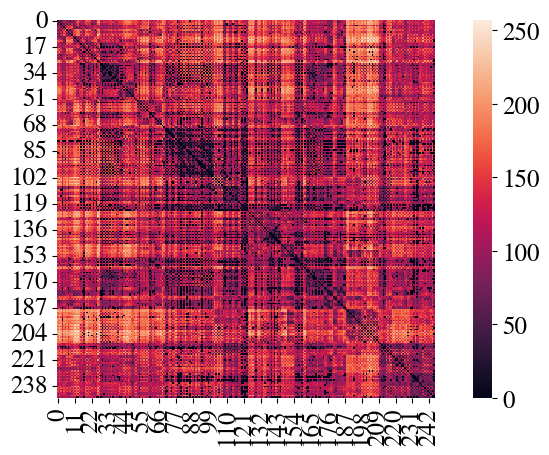

In [10]:
dist_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["Dist_template"]
sns.heatmap(dist_mat, square=1)



In [22]:
# some fn to get SA
# optimization
from scipy.optimize import minimize
def _reg_yx(vec, bins, bin_idxs):
    yv = []
    xv = []
    for i in np.sort(list(set(bin_idxs))):
        xv.append(bins[i-1])
        yv.append(vec[bin_idxs==i].mean())
    return np.array(xv), np.array(yv)
# opt fn 
def _obj_f(x, data):
    """min obj_f
    """
    xv, yv = data
    sa_inf, sa_lam = x 
    left = (yv-sa_inf)/(1-sa_inf)
    right = np.exp(-xv/sa_lam)
    return np.sum((left-right)**2)
def _minimize(fun, x0s, bounds, args):
    """A simple wrapper of minimize to allow multiple initial pts
    """
    fn_v = []
    xs = []
    for x0 in x0s:
        res = minimize(fun, x0, bounds=bounds, args=args)
        xs.append(res.x)
        fn_v.append(res.fun)
    return xs[np.argmin(fn_v)]
def _get_SA(fc, dist_mat, nbin=10):
    ui = np.triu_indices(fc.shape[0], 1)
    dist_vec = dist_mat[ui];
    bins = np.arange(np.min(dist_vec),  np.max(dist_vec), nbin)
    bin_idxs = np.digitize(dist_vec, bins);
    fc_vec = fc[ui]
        
    # initial value and bds
    # (sa_inf, sa_lam)
    x0s = ([-0.5, 25], [0, 50], [0.5, 75])
    eps = 1e-5
    bounds = [(-1+eps, 1-eps), (0+eps, 100)]

    # get fitting
    xv, yv = _reg_yx(fc_vec, bins, bin_idxs);
    res = _minimize(_obj_f, x0s, bounds=bounds, args=([xv, yv], ))
    return res

### Regular SA

In [23]:
for net_ix in range(1, 8):
    cur_ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]]
    cur_dist_mat = dist_mat[yeo_7nets_lab==net_ix][:, yeo_7nets_lab==net_ix]
    SAs = []
    for sub_ix in trange(1, num_sps+1, desc=f"{yeo_7nets_dict[net_ix]}"):
        ts = cur_ts[sub_ix-1]
        fc = _get_fc(ts)
        cur_SA = _get_SA(fc, cur_dist_mat, nbin=10)
        SAs.append(cur_SA)
    save_pkl(RES_ROOT/f"SAs_{yeo_7nets_dict[net_ix]}.pkl", SAs, is_force=1)

Visual: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 69.36it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/SAs_Visual.pkl


Somatomotor: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 71.19it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/SAs_Somatomotor.pkl


Dorsal_Attention: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 71.84it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/SAs_Dorsal_Attention.pkl


Ventral_Attention: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 74.50it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/SAs_Ventral_Attention.pkl


Limbic: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 72.39it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/SAs_Limbic.pkl


Frontoparietal: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 71.60it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/SAs_Frontoparietal.pkl


Default: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 71.35it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/SAs_Default.pkl


###  Ball SA

To be done

In [27]:
# get ball SA
bcorFCs = load_pkl(RES_ROOT/"bcorFCs.pkl");

Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/bcorFCs.pkl


In [57]:
# reg FC vs ball FC
std_fn = lambda x: (x-np.mean(x))/np.std(x)
sub_ix = 2
nbin = 5 
yvs = []
byvs = []
for sub_ix in trange(1, num_sps+1):
    bfc = bcorFCs[sub_ix-1]
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    fc = _get_fc(ts)
    
    dist_vec = dist_mat[ui];
    bins = np.arange(np.min(dist_vec),  np.max(dist_vec), nbin)
    bin_idxs = np.digitize(dist_vec, bins);
    
    
    bfc_vec = bfc[ui]
    fc_vec = fc[ui]
    xv, yv = _reg_yx(fc_vec, bins, bin_idxs);
    bxv, byv = _reg_yx(bfc_vec, bins, bin_idxs);
    yvs.append(yv)
    byvs.append(byv)

yvs = np.array(yvs)
byvs = np.array(byvs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 66.51it/s]


In [59]:
ballSAs = []
for sub_ix in trange(1, num_sps+1):
    fc = bcorFCs[sub_ix-1]
    cur_SA = _get_SA(fc, dist_mat, nbin=5)
    ballSAs.append(cur_SA)
save_pkl(RES_ROOT/"ballSAs.pkl", ballSAs, is_force=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:07<00:00, 45.65it/s]

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/ballSAs.pkl


# Analyasis

In [16]:
from scipy.stats import f_oneway, ttest_ind 

In [17]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

## TAs

### Regular TA

In [24]:
for net_ix in range(1, 8):
    TAs = load_pkl(RES_ROOT/f"TAs_{yeo_7nets_dict[net_ix]}.pkl", verbose=False);
    metrics = np.array([np.mean(TA) for TA in TAs])
    
    res_df = pd.DataFrame({
        "metric": metrics, 
        "sex": sex_labs, 
        "diagnosis": diag_labs
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"Network is {yeo_7nets_dict[net_ix]}")
    print(_get_test_tb(res_df))

Network is Visual
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.055 |     0.285   |
|    bvFTD vs HC |  0.075 |    -0.328   |
|      CBS vs HC |  0.522 |     0.139   |
|   nfvPPA vs HC |  0.999 |    -0.000   |
|    svPPA vs HC |  0.479 |    -0.136   |
| Dementia vs HC |  0.761 |     0.037   |
|          ANOVA |  0.056 |             |
+----------------+--------+-------------+
Network is Somatomotor
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.537 |    -0.092   |
|    bvFTD vs HC |  0.125 |    -0.284   |
|      CBS vs HC |  0.557 |    -0.127   |
|   nfvPPA vs HC |  0.360 |    -0.182   |
|    svPPA vs HC |  0.634 |     0.092   |
| Dementia vs HC |  0.338 |    -0.115   |
|          ANOVA |  0.558 |             |
+----------------+--------+-------------+
Network is Dorsal_Attention
+------

### ball TA

In [27]:
for net_ix in range(1, 8):
    TAs = load_pkl(RES_ROOT/f"ballTAs_{yeo_7nets_dict[net_ix]}.pkl", verbose=False);
    metrics = TAs
    
    res_df = pd.DataFrame({
        "metric": metrics, 
        "sex": sex_labs, 
        "diagnosis": diag_labs
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"Network is {yeo_7nets_dict[net_ix]}, under ball corr")
    print(_get_test_tb(res_df))

Network is Visual, under ball corr
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|      *AD vs HC |  0.002 |     0.456   |
|    bvFTD vs HC |  0.161 |    -0.259   |
|      CBS vs HC |  0.469 |     0.157   |
|   nfvPPA vs HC |  0.863 |     0.034   |
|    svPPA vs HC |  0.248 |     0.222   |
| Dementia vs HC |  0.120 |     0.187   |
|         *ANOVA |  0.004 |             |
+----------------+--------+-------------+
Network is Somatomotor, under ball corr
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|        AD vs HC |  0.181 |     0.199   |
|     bvFTD vs HC |  0.055 |     0.355   |
|       CBS vs HC |  0.121 |     0.335   |
|    nfvPPA vs HC |  0.204 |     0.252   |
|    *svPPA vs HC |  0.005 |     0.533   |
| *Dementia vs HC |  0.009 |     0.314   |
|           ANOVA |  0.060 |             |
+-----------------+--------+-----

##  SAs

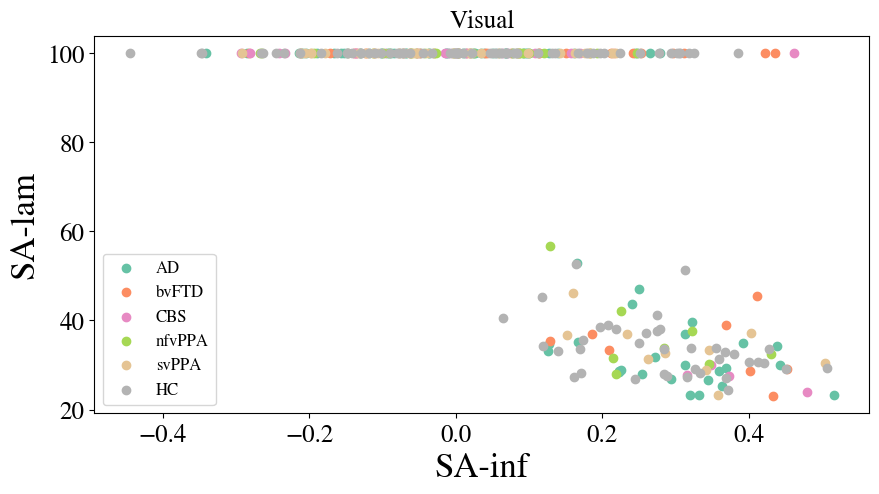

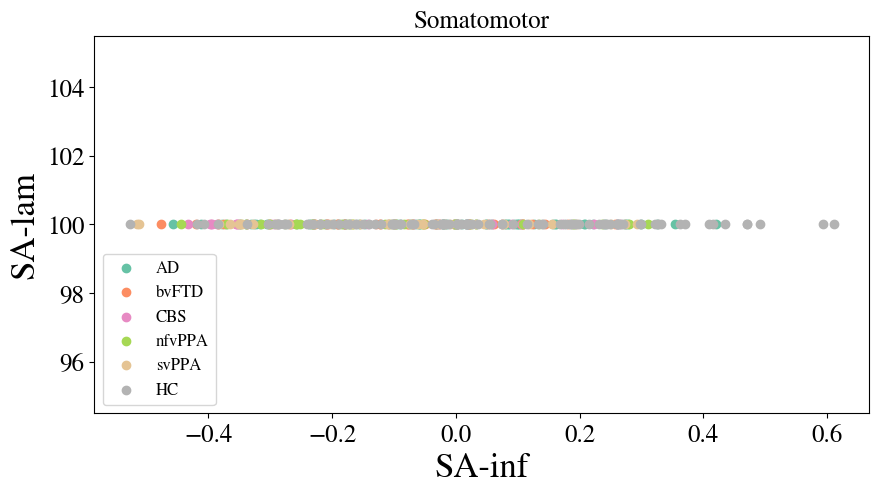

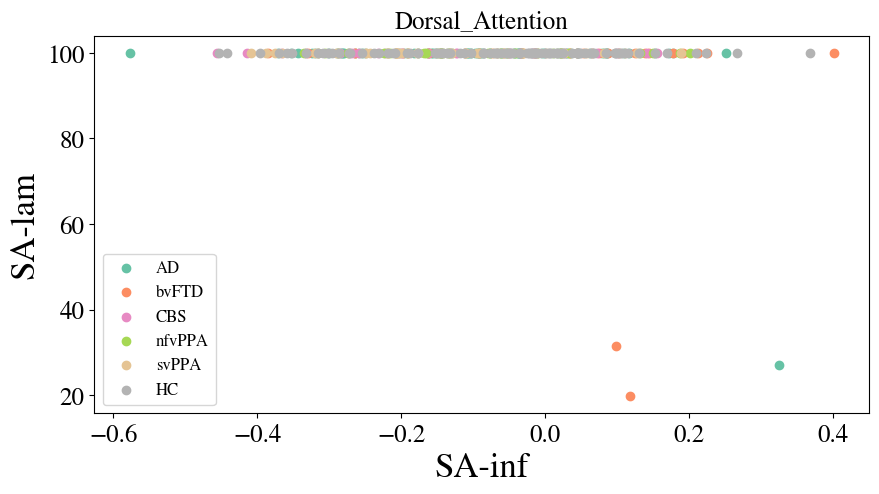

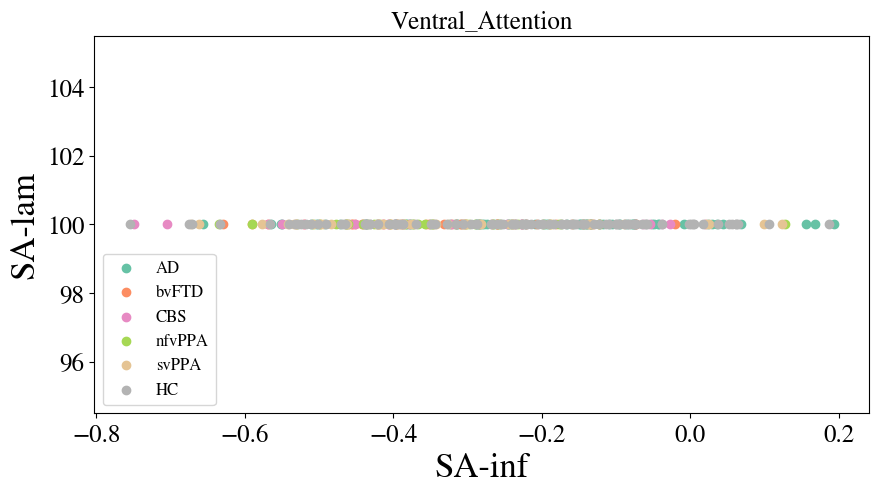

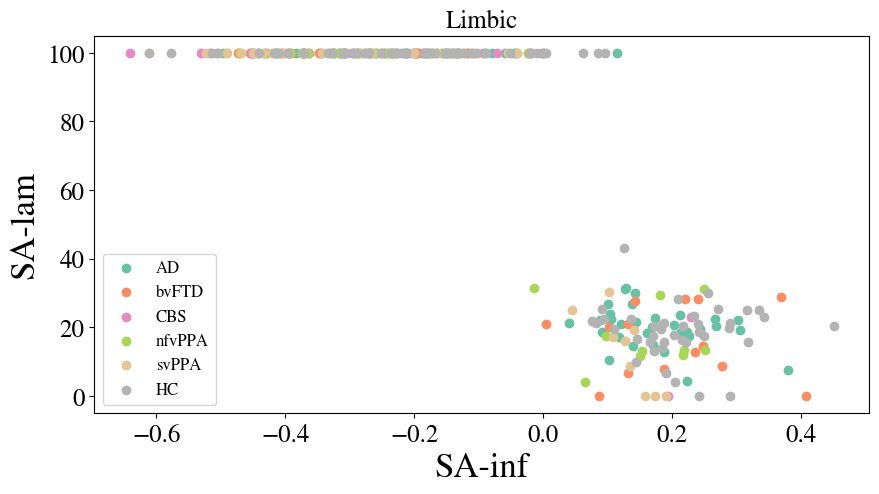

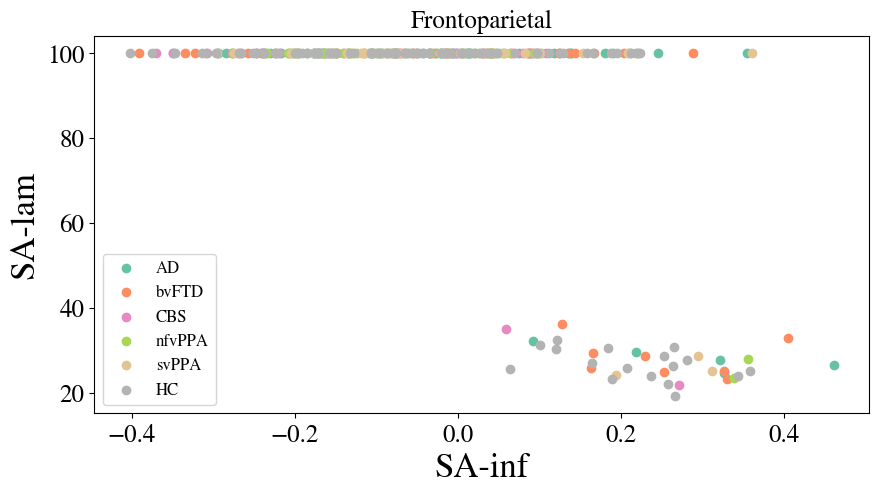

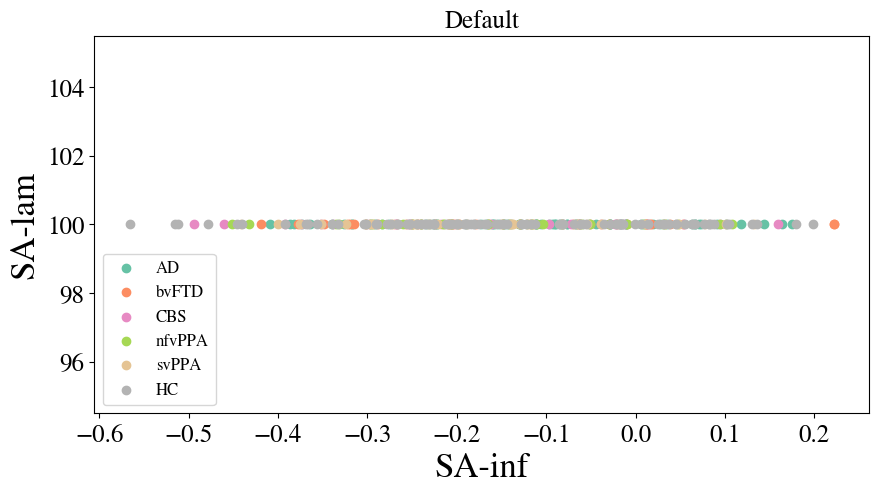

In [24]:
cols = qual_cmap(len(set(diag_labs)))
for net_ix in range(1, 8):

    SAs = np.array(load_pkl(RES_ROOT/f"SAs_{yeo_7nets_dict[net_ix]}.pkl", verbose=False));
    metricss = SAs
    #for ix in [1, 6]:
    for ix in range(1, len(set(diag_labs))+1):
        plt.scatter(x=metricss[diag_labs==ix, 0], y=metricss[diag_labs==ix, 1], color=cols[ix-1], label=diag_lab_mapping[ix])
    plt.xlabel("SA-inf")
    plt.ylabel("SA-lam")
    plt.title(f"{yeo_7nets_dict[net_ix]}")
    plt.legend(loc="lower left", fontsize=12)
    plt.show()
    plt.close()